In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import stan
import matplotlib.pyplot as plt
from scipy.special import ndtri
from scipy.stats import norm, lognorm

import pickle


In [2]:
fname = 'results_raw.pickle'
# Create a writer object
file = open(fname, 'rb')

# dump information
results_decision = pickle.load(file)

# close file
file.close()

fname = 'results_raw_50.pickle'
# Create a writer object
file = open(fname, 'rb')

# dump information
results_decision_50 = pickle.load(file)

# close file
file.close()

fname = 'results_raw_25.pickle'
# Create a writer object
file = open(fname, 'rb')

# dump information
results_decision_25 = pickle.load(file)

# close file
file.close()

In [3]:
df_25 = pd.concat(results_decision_25, names=['subject'])
df_50 = pd.concat(results_decision_50, names=['subject'])

results_decision_50.keys()
df = results_decision_50['11112']

In [4]:
mu_theta, mu_Lambda, mu_tau, mu_alpha, mu_gamma = -1.32617141, 0.41613512, -1.37750916, -0.24550931, -0.13804112
sig_theta, sig_Lambda, sig_tau, sig_alpha, sig_gamma = 0.19484903, 0.71492692,  0.17975801, 0.08284753, 0.67868274
sig_error = 1.9222773
x0 = np.array([mu_theta, sig_theta, mu_Lambda, sig_Lambda, mu_tau, sig_tau, mu_alpha, sig_alpha, mu_gamma, sig_gamma, sig_error])

distro_estimates = {'mu':{'theta': x0[0], 'Lambda': x0[2], 'tau': x0[4], 'alpha': x0[6], 'gamma': x0[8]},
                         'sigma':{'theta': x0[1], 'Lambda': x0[3], 'tau': x0[5], 'alpha': x0[7],  'gamma': x0[9], 'error':x0[10]}}
distro_estimates_export = pd.DataFrame(distro_estimates)
distro_estimates_export['exp(mu)'] = np.exp(distro_estimates_export['mu'])
distro_estimates_export.to_csv('distro_estimates_errors_tau_repeat.csv')
distro_estimates_export


THETA_INIT = 0.42
LAMBDA_INIT = 1.6
TAU_INIT = .28
ALPHA_INIT = .9
GAMMA_INIT = .7
ERROR_INIT = 0

stan_data['beta'] = 0.88

NameError: name 'stan_data' is not defined

In [ ]:

import time

start_time = time.time()

# Add beta to stan_data, as it is used in the Stan model
beta = 0.88

# Prepare stan_data dictionary
stan_data = {
    'N': len(df),
    'gain': df['gain'].values,
    'loss': df['loss'].values,
    'prob_win': df['prob_win'].values,
    'prob_loss': df['prob_loss'].values,
    'prob_ambi': df['prob_ambi'].values,
    'invest': df['invest'].astype(int).values,
    'mu_theta': mu_theta,
    'sigma_theta': sig_theta,
    'mu_Lambda': mu_Lambda,
    'sigma_Lambda': sig_Lambda,
    'mu_tau': mu_tau,
    'sigma_tau': sig_tau,
    'mu_alpha': mu_alpha,
    'sigma_alpha': sig_alpha,
    'mu_gamma': mu_gamma,
    'sigma_gamma': sig_gamma,
    'sigma_error': sig_error,
    'beta': beta
}

import nest_asyncio
nest_asyncio.apply()





# # Set initial values for the parameters
# init_values = {
#     'theta': 0,
#     'Lambda': LAMBDA_INIT,
#     'tau': TAU_INIT,
#     'alpha': ALPHA_INIT,
#     'gamma': GAMMA_INIT,
#     'error': ERROR_INIT
# }



# Update Stan model code to accept beta as data
stan_model_code = """
data {
    int<lower=0> N; // number of observations
    vector[N] gain; // gains
    vector[N] loss; // losses
    vector[N] prob_win; // probability of winning
    vector[N] prob_loss; // probability of losing
    vector[N] prob_ambi; // probability of ambiguity
    array[N] int<lower=0, upper=1> invest; // observed investment decisions

    real mu_theta;
    real sigma_theta;
    real mu_Lambda;
    real sigma_Lambda;
    real mu_tau;
    real sigma_tau;
    real mu_alpha;
    real sigma_alpha;
    real mu_gamma;
    real sigma_gamma;
    real sigma_error;
    real beta; // <-- added beta as data
}

parameters {
    real<lower=0> theta; // parameter theta
    real<lower=0> Lambda; // parameter Lambda
    real<lower=0> tau; // parameter tau
    real<lower=0> alpha; // parameter alpha
    real<lower=0> gamma; // parameter gamma
    real error; // error term
}

model {
    // Priors
    theta ~ lognormal(mu_theta, sigma_theta);
    Lambda ~ lognormal(mu_Lambda, sigma_Lambda);
    tau ~ lognormal(mu_tau, sigma_tau);
    alpha ~ lognormal(mu_alpha, sigma_alpha);
    gamma ~ lognormal(mu_gamma, sigma_gamma);
    error ~ normal(0, sigma_error);

    // Likelihood
    for (n in 1:N) {
        real utility = (gain[n] >= 0 ? pow(gain[n], alpha) : -Lambda * pow(-gain[n], beta)) * 
                       pow(prob_win[n] + prob_ambi[n] * theta, gamma) +
                       (loss[n] >= 0 ? pow(loss[n], alpha) : -Lambda * pow(-loss[n], beta)) * 
                       pow(prob_loss[n] + prob_ambi[n] * (1 - theta), gamma);
        
        invest[n] ~ bernoulli_logit(tau * (utility - error));
    }
}
"""


# Compile the Stan model (synchronously in Jupyter)
posterior = stan.build(stan_model_code, data=stan_data)

# Fit the model
stan_fit = posterior.sample(num_chains=4, num_samples=1000)

stan_time = time.time() - start_time



Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   1% (100/8000)
Sampling:   1% (101/8000)
Sampling:   9% (701/8000)
Sampling:  10% (801/8000)
Sampling:  15% (1201/8000)
Sampling:  20% (1600/8000)
Sampling:  38% (3000/8000)
Sampling:  40% (3200/8000)
Sampling:  45% (3600/8000)
Sampling:  65% (5200/8000)
Sampling:  8

<stan.Fit>
Parameters:
    theta: ()
    Lambda: ()
    tau: ()
    alpha: ()
    gamma: ()
    error: ()
Draws: 4000


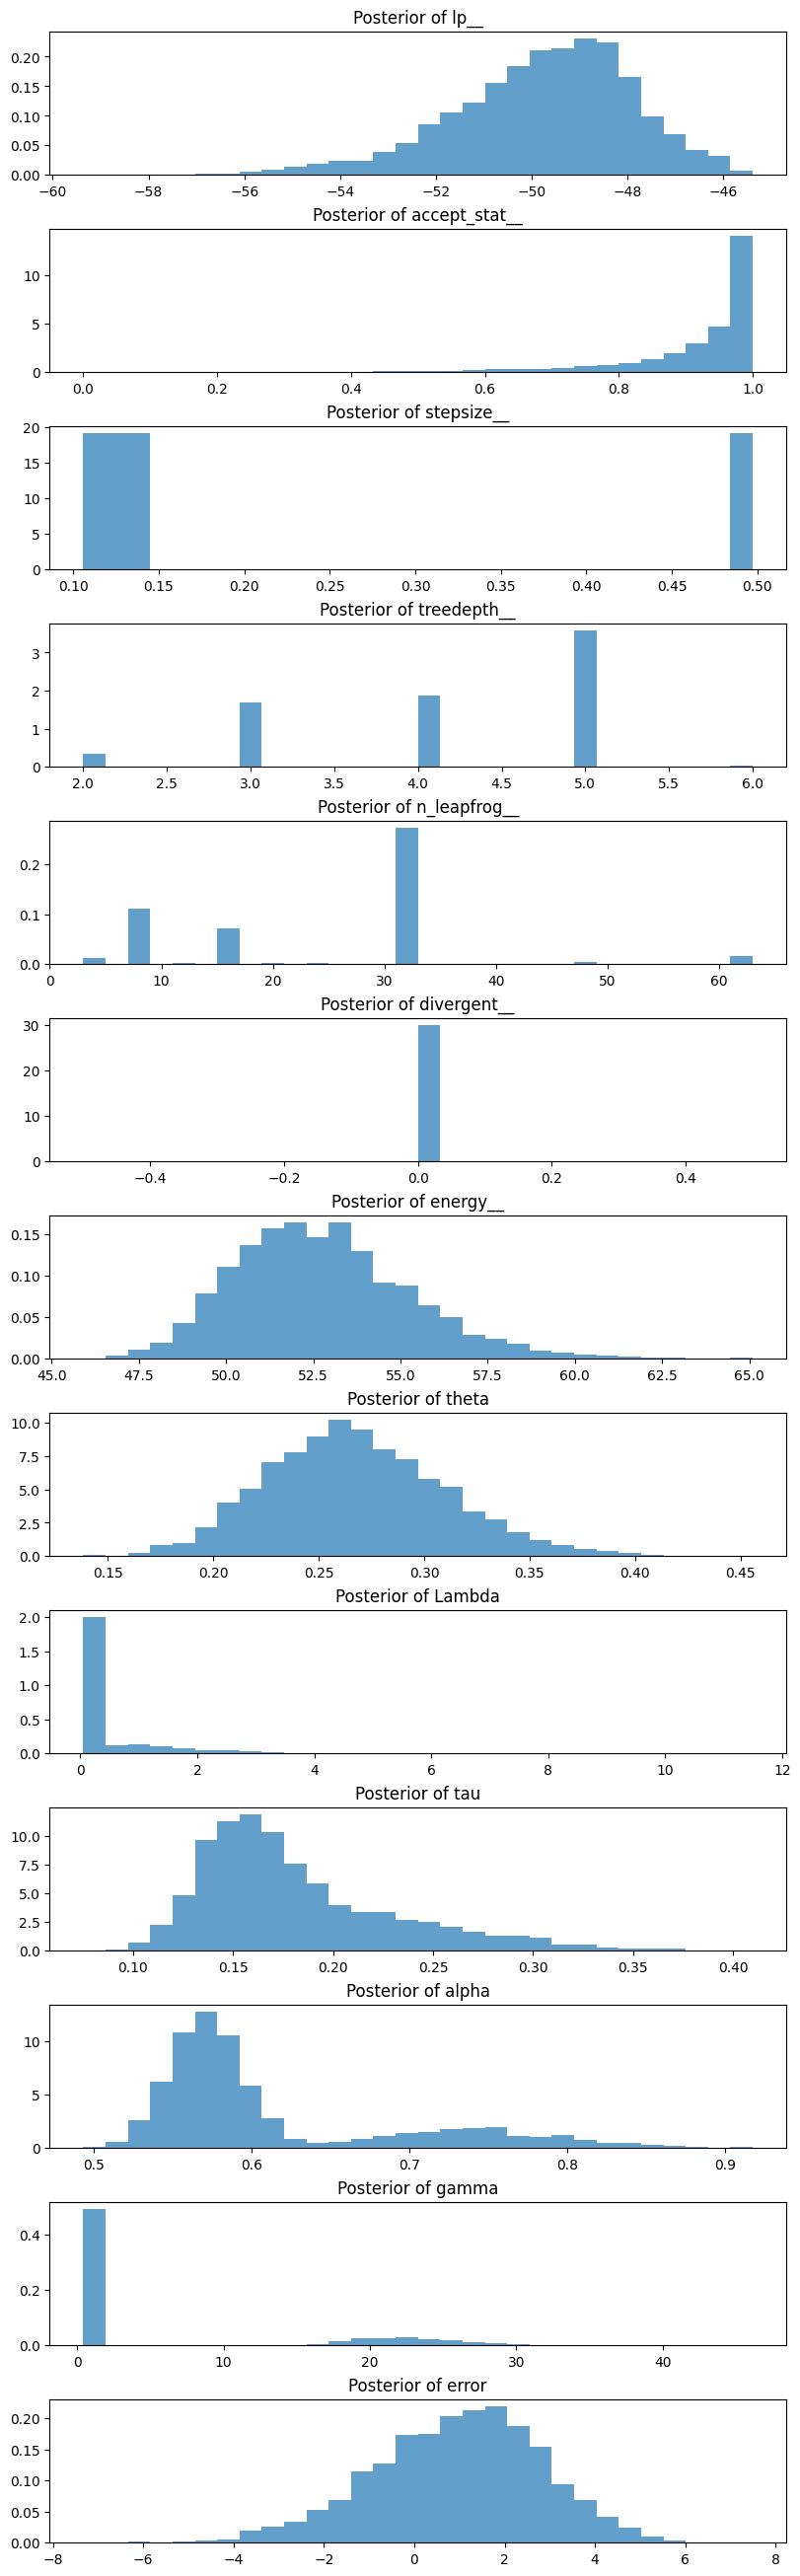

In [6]:
# Print the results
print(stan_fit)

# Plot posterior distributions for all parameters
import matplotlib.pyplot as plt

samples = stan_fit.to_frame()
fig, axes = plt.subplots(len(samples.columns), 1, figsize=(8, 2 * len(samples.columns)), constrained_layout=True)
if len(samples.columns) == 1:
	axes = [axes]
for ax, col in zip(axes, samples.columns):
	ax.hist(samples[col], bins=30, density=True, alpha=0.7)
	ax.set_title(f'Posterior of {col}')
plt.show()

In [7]:
print(stan_fit.to_frame().describe()[['theta', 'Lambda', 'tau', 'alpha', 'gamma', 'error']].T)


             count      mean       std       min       25%       50%  \
parameters                                                             
theta       4000.0  0.267841  0.042455  0.138348  0.238100  0.265162   
Lambda      4000.0  0.496212  0.950848  0.049655  0.092232  0.110153   
tau         4000.0  0.182070  0.049516  0.075162  0.147419  0.168726   
alpha       4000.0  0.613835  0.081925  0.493273  0.560868  0.580392   
gamma       4000.0  6.169779  9.807102  0.424225  0.589370  0.633855   
error       4000.0  0.954972  1.870820 -7.325438 -0.234972  1.082975   

                 75%        max  
parameters                       
theta       0.295087   0.455769  
Lambda      0.196439  11.496937  
tau         0.205032   0.409699  
alpha       0.630063   0.917638  
gamma       4.333812  46.147759  
error       2.264618   7.491233  


mu_theta, mu_Lambda, mu_tau, mu_alpha, mu_gamma      = -1.32617141, 0.41613512, -1.37750916, -0.24550931, -0.13804112
sig_theta, sig_Lambda, sig_tau, sig_alpha, sig_gamma = 0.19484903, 0.71492692,  0.17975801, 0.08284753, 0.67868274
sig_error = 1.9222773
